# Introduction

In the first two parts of this Data Science project, we explored the "Brazilian E-Commerce Public Dataset by Olist" and worked on manipulating and visualizing the data. Now, in the third and final part, our goal is to predict customer satisfaction based on the review score using machine learning models.

Based on the variables we identified in the first part as relevant to customer satisfaction and the visualizations created in the second part, we will train different machine learning models to predict customer satisfaction based on the available information.

In this step, we will use data preprocessing, cross-validation, and hyperparameter optimization techniques to ensure that our models are fit and optimized for the given dataset.

Importantly, the previous stages of this project have been critical in getting us this far. In the [first part](https://www.kaggle.com/code/gustavofelici/1-understanding-business-and-data-using-sql/notebook), we understood the context of the data and identified the most important variables for customer satisfaction. In the [second part](https://www.kaggle.com/code/gustavofelici/2-data-manipulation-and-visualization/notebook), we cleaned and organized the data, created visualizations, and better understood the relationships between the variables.

Now, in the third part, we will use everything we learned to predict customer satisfaction based on the review score. We hope that this work can contribute to a better understanding of the customer experience in Brazilian e-commerce and to the continuous improvement of the services offered by Olist.

# Libraries

In [90]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, make_scorer

import time

# Importing Features
Let's make an initial model with the variables and using a simple model, to get initial results and understand more about the model

In [92]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Olist/Output/Olist_model.csv')
df.head()

,Unnamed: 0,score,purchase_to_approved,approved_to_carrier,carrier_to_customer,estimated_to_customer,limit_to_carrier,has_sequential,has_installments,last_payment,...,avg_freight,avg_name_lenght,avg_description_name,avg_photos_qty,avg_weight_g,avg_length_cm,avg_height_cm,avg_width_cm,avg_same_city,avg_same_state
0,26,5.0,0,0,1,-4,-2,0,0,93.75,...,8.76,33.0,1127.0,2.0,450.0,16.0,4.0,20.0,0.0,1.0
1,27,3.0,0,0,1,-2,-2,0,0,33.23,...,8.33,54.0,429.0,1.0,450.0,28.0,9.0,19.0,0.0,1.0
2,28,5.0,0,0,1,-7,-2,0,0,61.29,...,15.39,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,0.0,1.0
3,29,5.0,0,0,1,-3,-2,0,1,510.96,...,46.48,44.0,112.0,1.0,13550.0,48.0,49.0,49.0,1.0,1.0
4,30,1.0,0,0,1,-2,-2,0,1,73.10,...,9.20,52.0,711.0,2.0,1500.0,28.0,22.0,18.0,1.0,1.0


In [93]:
df.shape

(52463, 21)

In [94]:
df = df.drop('Unnamed: 0', axis=1)

In [95]:
product = ['avg_name_lenght', 'avg_description_name', 'avg_photos_qty', 'avg_weight_g', 'avg_length_cm', 'avg_height_cm', 'avg_width_cm']

In [96]:
X = df.drop('score', axis=1)
y = df['score']
X.head()

,purchase_to_approved,approved_to_carrier,carrier_to_customer,estimated_to_customer,limit_to_carrier,has_sequential,has_installments,last_payment,avg_price,avg_freight,avg_name_lenght,avg_description_name,avg_photos_qty,avg_weight_g,avg_length_cm,avg_height_cm,avg_width_cm,avg_same_city,avg_same_state
0,0,0,1,-4,-2,0,0,93.75,84.99,8.76,33.0,1127.0,2.0,450.0,16.0,4.0,20.0,0.0,1.0
1,0,0,1,-2,-2,0,0,33.23,24.90,8.33,54.0,429.0,1.0,450.0,28.0,9.0,19.0,0.0,1.0
2,0,0,1,-7,-2,0,0,61.29,45.90,15.39,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,0.0,1.0
3,0,0,1,-3,-2,0,1,510.96,209.00,46.48,44.0,112.0,1.0,13550.0,48.0,49.0,49.0,1.0,1.0
4,0,0,1,-2,-2,0,1,73.10,63.90,9.20,52.0,711.0,2.0,1500.0,28.0,22.0,18.0,1.0,1.0


# First Model

In [97]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0, stratify=y)

`stratify=y` para separar os dados de forma uniforme porque os dados estão desbalanceados

In [98]:
model = make_pipeline(RobustScaler(), DecisionTreeClassifier(random_state=0))
model.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

In [99]:
y_pred = model.predict(X_test)

In [100]:
distribution = pd.DataFrame()

distribution['y_train'] = y_train.value_counts()
distribution['y_test'] = y_test.value_counts()
distribution['y_pred'] = pd.Series(y_pred).value_counts()
distribution['y_train_%'] = y_train.value_counts(normalize=True)
distribution['y_test_%'] = y_test.value_counts(normalize=True)
distribution['y_pred_%'] = pd.Series(y_pred).value_counts(normalize=True)

distribution

,y_train,y_test,y_pred,y_train_%,y_test_%,y_pred_%
5.0,24910,6228,6023,0.593519,0.593539,0.574002
4.0,8091,2023,2127,0.192781,0.192795,0.202707
1.0,4332,1083,1087,0.103217,0.103212,0.103593
3.0,3375,844,918,0.080415,0.080435,0.087487
2.0,1262,315,338,0.030069,0.030020,0.032212


In [101]:
metrics = {
    'Accuracy': accuracy_score(y_pred, y_test),
    'F1': f1_score(y_pred, y_test, average = 'macro'),
    'Recall': recall_score(y_pred, y_test, average = 'macro', zero_division=1),
    'Precision': precision_score(y_pred, y_test, average = 'macro')
}
metrics

{'Accuracy': 0.45039550176308013,
 'F1': 0.25635894622930805,
 'Recall': 0.25635755259619,
 'Precision': 0.25656668758088447}

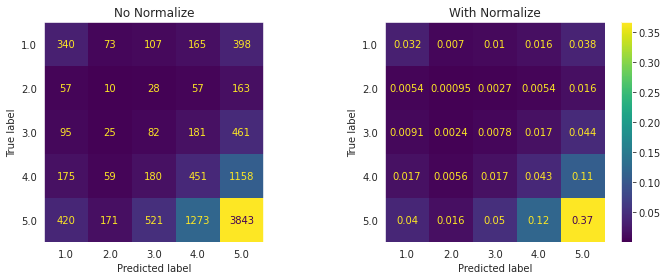

In [102]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax[1])

ax[0].set_title('No Normalize')
ax[0].grid(False)

ax[1].set_title('With Normalize')
ax[1].grid(False)

fig.tight_layout()
plt.show()

The algorithm is predicting a majority of the results as score=5. We get a very low accuracy of 44%, and our errors according to recall (false negative rate) and precision (false positive rate) are evenly distributed

# Algorithms Testing
Let's understand between several algorithms to see which performs best

In [103]:
algorithms = {
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=0),
    'XGB': XGBClassifier(random_state=0),
    'LGBM': LGBMClassifier(random_state=0),
    'GBC' : GradientBoostingClassifier(random_state=0)
}

In [104]:
def test_algorithms(X,y):
  # Fit Algorithms
  result = pd.DataFrame()
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  
  scoring = {'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='macro', zero_division=1),
            'recall': 'recall_macro',
            'f1': 'f1_macro'}

  for key, algorithm in algorithms.items():
    start_time = time.time()
    print(f'{key}...', end = '')
    model = make_pipeline(RobustScaler(), algorithm)

    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_estimator =True)

    new_row = {
        'Algorithm': key,
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'F1': np.mean(cv_results['test_f1']),
        'Recall': np.mean(cv_results['test_recall']),
        'Precision': np.mean(cv_results['test_precision']),
        'model': cv_results['estimator'],
        'run_time': (time.time() - start_time) / 60
      }

    result = result.append(new_row, ignore_index=True)
    print(f'finished!!! {(time.time() - start_time) / 60} min(s).')
      
  return result.sort_values(by='Accuracy').set_index('Algorithm', drop=True)

## Comparison

In [ ]:
results = test_algorithms(X,y)

Decision Tree...finished!!! 0.2195200483004252 min(s).
Naive Bayes...finished!!! 0.02052457332611084 min(s).
KNN...finished!!! 2.1711084246635437 min(s).
Random Forest...finished!!! 3.467484692732493 min(s).
XGB...finished!!! 3.0805559436480205 min(s).
LGBM...

In [ ]:
results['run_time'].sum()

In [ ]:
results

# Visualize

In [ ]:
def visualize_results():
  fig, (ax1,ax2) = plt.subplots(2,2, figsize=(30,8))

  results['Accuracy'].plot(kind='line', title='Accuracy', ax=ax1[0])
  results['F1'].plot(kind='line', title='F1', ax=ax1[1])
  results['Recall'].plot(kind='line', title='Recall', ax=ax2[0])
  results['Precision'].plot(kind='line', title='Precision', ax=ax2[1])
  fig.tight_layout()
  plt.plot()
  plt.figure(figsize=(15,4))
  sns.lineplot(data=results, x='Algorithm', y='run_time')

In [ ]:
visualize_results()

Vemos um destaque na accuracy do XGB sendo a maior, porém não possui um f1 alto e possui um recall muito alto, oque pode mostrar erros que o modelo não está prevendo ou ele está prevendo a mesma coisa, como no nosso primeiro modelo, então é melhor a gente ver a matrix de confusão para chegar a uma conclusão mais detalhada

## Confusion Matrix

In [ ]:
results['model']['XGB'][0]

In [ ]:
def results_confusion_matrix():
  fig, (ax1,ax2) = plt.subplots(2,len(results.index), figsize=(30,8))
  metrics = pd.DataFrame()
  i=0

  for algorithm in results.index:

    model = results['model'][algorithm][0]
    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax1[i], colorbar=False)
    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax2[i], colorbar=False, normalize='all')

    ax1[i].set_title(algorithm)
    ax1[i].grid(False)
    ax2[i].set_title(algorithm)
    ax2[i].grid(False)
    i+=1

  fig.tight_layout()

In [ ]:
results_confusion_matrix()

After running cross-validation on several models to predict my target that varies from 1 to 5, I noticed that the Random Forest model presented the best result in relation to the others. Then, I decided to analyze the confusion matrix to better understand the models' performance.

Observing the matrix, I noticed that the other models were concentrating their predictions mainly on the value 5 of my target, while the Random Forest model presented a better predictability for all the values of my target, hitting several values of Score.

With this, I understood that the other models could be suffering from a class imbalance problem, since the value 5 was the most common in my training data, and therefore, they were focusing on predicting this value.

The Random Forest model performed better, because by combining several decision tree models it is able to handle different feature importance and more accurately predict values other than 5.

So, my conclusion is that the Random Forest model is the best choice for predicting my target values because it had the best predictability for all classes.

# Feature Importances

In [ ]:
results['model']['XGB'][0][1]

In [ ]:
indexs = ['Decision Tree', 'Random Forest', 'XGB', 'LGBM', 'GBC']
i = 0
fig, ax = plt.subplots(ncols=len(indexs), figsize=(30,4))

for index in indexs:
  estimator = results['model'][index][0][1]
  sort = estimator.feature_importances_.argsort()
  sns.barplot(y=X.columns[sort], x=estimator.feature_importances_[sort], ax=ax[i], orient='h')
  ax[i].set_title(index)
  i+=1

fig.tight_layout()
plt.show()

# Hyper Parameter Tunning
I decided to optimize the Random Forest model according to the f1 score and after the optimization I noticed a significant improvement in its performance. Based on this, I decided to choose Random Forest as the final model to predict my target values.

## Random Forest

In [61]:
param_grid = {'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]}
f1 = make_scorer(f1_score, average='macro')

In [62]:
#start_time = time.time()
#grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=3, scoring=f1)
#grid_search.fit(X_train, y_train)
#grid_time = (time.time() - start_time) / 60
#grid_time

Executio Time: `36.45` mins


grid_search.best_params_
```
{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}
```



Agora vamos comparar ele com os outros algoritmos

In [63]:
algorithms = {}
algorithms['Otimized Random Forest'] = RandomForestClassifier(random_state=0, criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 10)
algorithms

{'Otimized Random Forest': RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=10,
                        random_state=0)}

In [64]:
otimized_rf = test_algorithms(X, y)
otimized_rf

Otimized Random Forest... finished!!! 0.17863620122273763 min(s).


,Accuracy,F1,Recall,Precision,model,run_time
Algorithm,,,,,,
Otimized Random Forest,0.624307,0.247922,0.271743,0.313069,"[(RobustScaler(), (DecisionTreeClassifier(crit...",0.178575


In [65]:
results = results.append(otimized_rf).sort_values(by='Accuracy')
results

,Accuracy,F1,Recall,Precision,model,run_time
Algorithm,,,,,,
Decision Tree,0.443563,0.255080,0.256276,0.254427,"[(RobustScaler(), DecisionTreeClassifier(rando...",0.134489
KNN,0.532998,0.272094,0.271813,0.287763,"[(RobustScaler(), KNeighborsClassifier()), (Ro...",0.502946
Naive Bayes,0.583059,0.249522,0.274840,0.289318,"[(RobustScaler(), GaussianNB()), (RobustScaler...",0.014673
Random Forest,0.608314,0.264761,0.277123,0.327079,"[(RobustScaler(), (DecisionTreeClassifier(max_...",2.356507
Otimized Random Forest,0.624307,0.247922,0.271743,0.313069,"[(RobustScaler(), (DecisionTreeClassifier(crit...",0.178575
LGBM,0.625050,0.249880,0.274945,0.358013,"[(RobustScaler(), LGBMClassifier(random_state=...",0.620360
GBC,0.625616,0.249521,0.274832,0.336884,"[(RobustScaler(), ([DecisionTreeRegressor(crit...",9.297534
XGB,0.626245,0.248599,0.274193,0.634308,"[(RobustScaler(), XGBClassifier(objective='mul...",2.268910


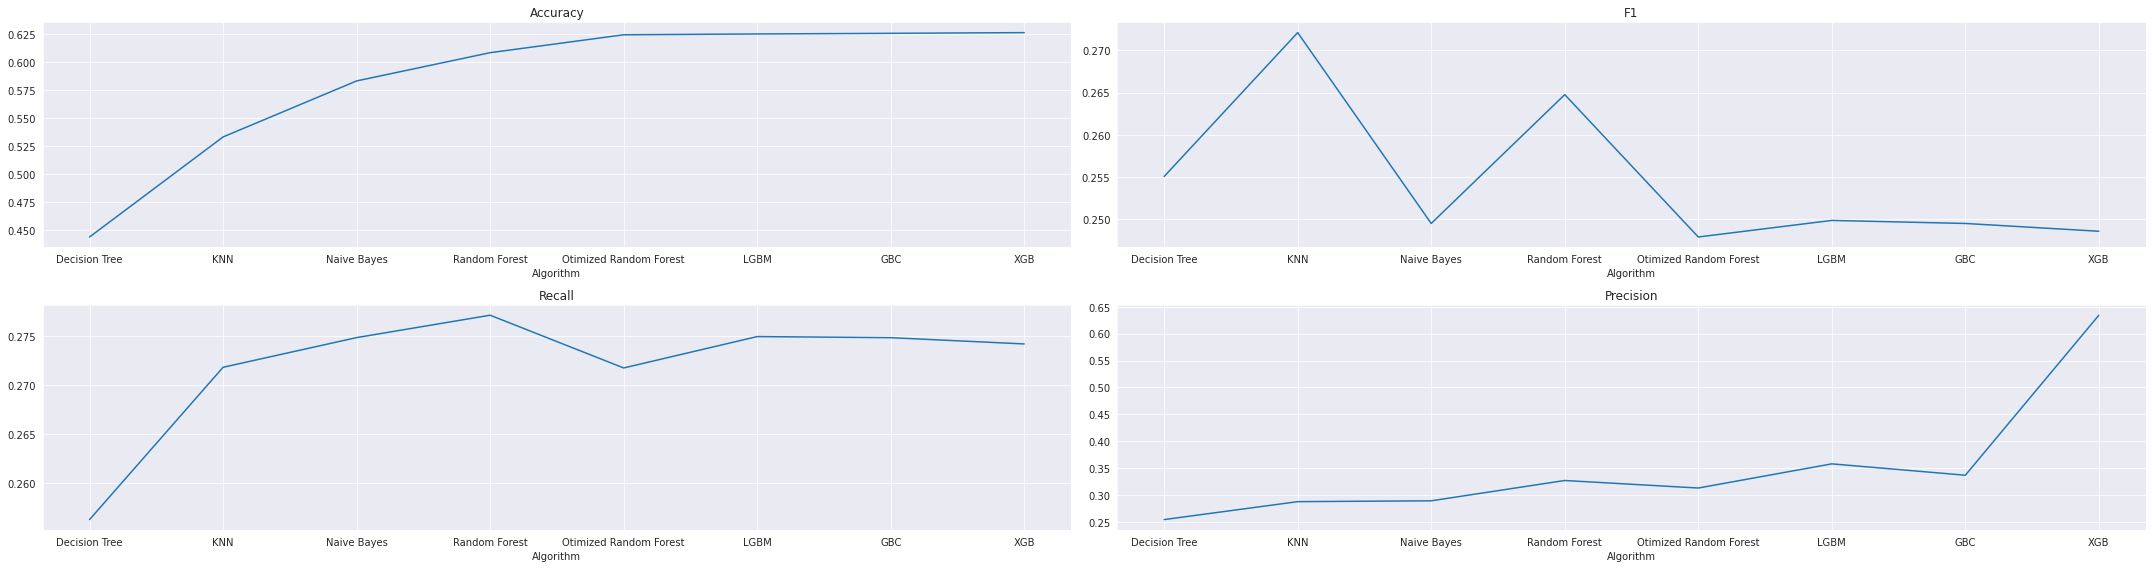

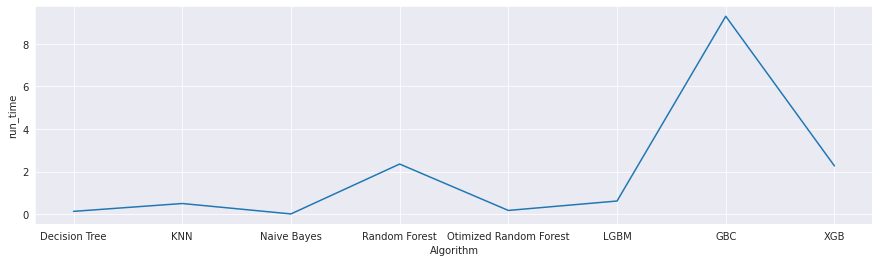

In [66]:
visualize_results()

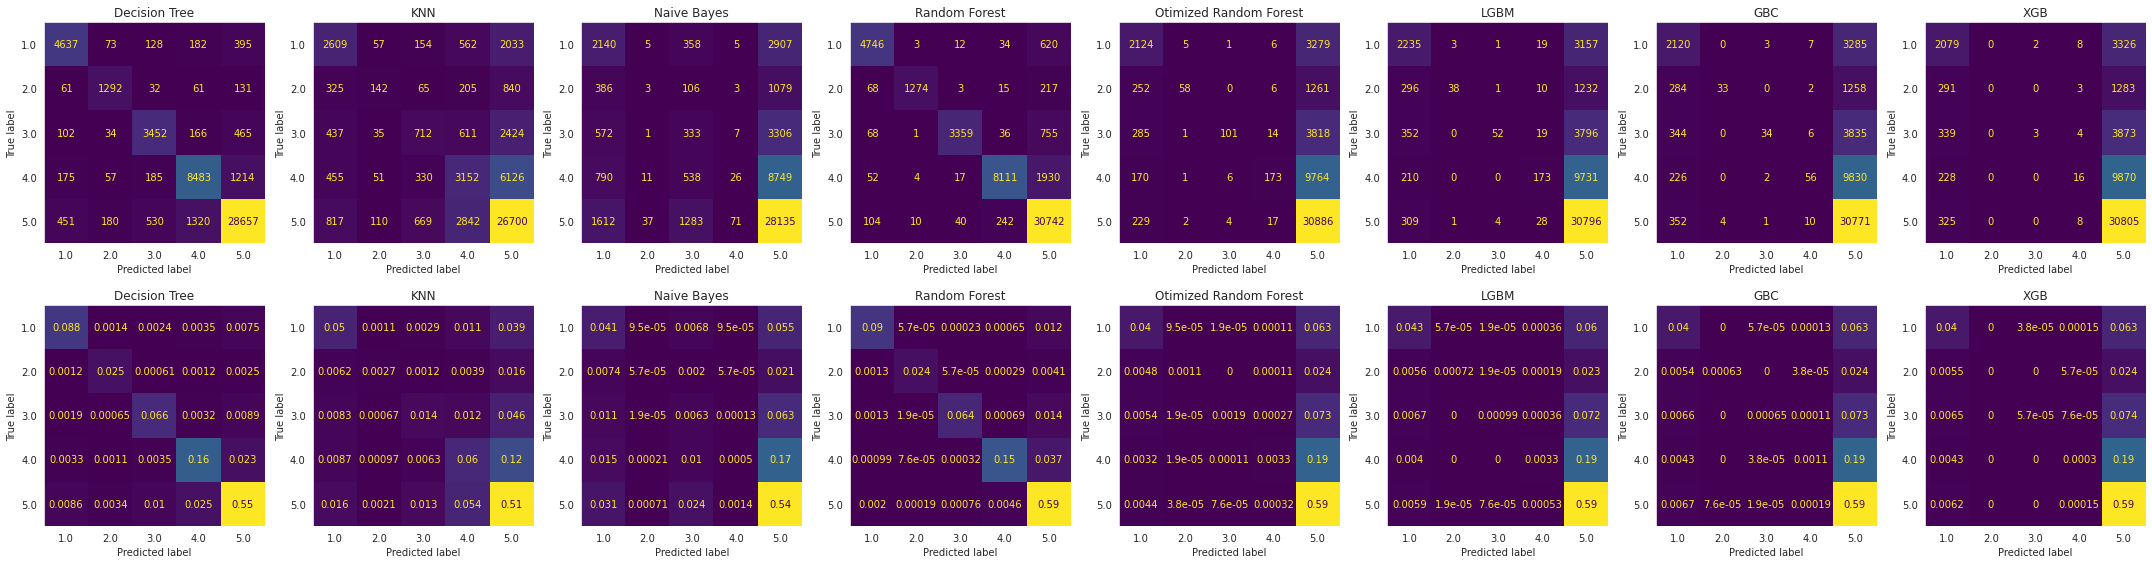

In [67]:
results_confusion_matrix()

# Conclusion

When evaluating the results of the different models, we concluded that the random forest algorithm showed the best performance in terms of accuracy and f1 score. We then used hyperparameter optimization techniques to adjust the model and obtain an even better performance.

This project was an opportunity to better understand how the Brazilian e-commerce works and how customer satisfaction can be predicted from variables such as product category, freight value and delivery time.

I would like to thank everyone who has followed this project up to this point and I hope that the information presented can be useful to those who work in the area of e-commerce and data analysis. I am available to answer any questions or comments about this project.